# Self-calibration

We have partially automated the cleaning and self-calibration process.  This document describes how you can use the self-cal scripts to clean a target field.

The general process is:

1. Produce a dirty image
1. Create a mask based on that dirty image, using either the [region-based threshold approach](https://github.com/ALMA-IMF/reduction/blob/master/reduction/make_custom_mask.py) (see below) or CRTF region files (i.e., regions drawn onto the image as you normally do in an interactive clean session).
1. Clean within that first mask region to a moderate depth
1. Create a new mask
1. Perform a phase-only self-calibration
1. Reject any _fields_ in the self-calibration with inadequate signal-to-noise using [heuristics](https://github.com/ALMA-IMF/reduction/blob/master/reduction/selfcal_heuristics.py).  This stage is essential for our mosaiced fields, in which some pointings will have no signal at all.
1. Apply the self-calibration solutions
1. Clean with the new mask to a somewhat greater depth
1. Create a new mask
1. Repeat steps 5-9 above

Then, after a few iterations of phase-only self-calibration, perform one or more iterations of amplitude self-calibration

## Imaging Parameters

To make the above approach straightforward, this is all wrapped into a [script](https://github.com/ALMA-IMF/reduction/blob/master/reduction/continuum_imaging_selfcal.py), and users only need modify the [parameters](https://github.com/ALMA-IMF/reduction/blob/master/reduction/imaging_parameters.py).

The parameters include the following global defaults as inputs to `tclean`:

```
                      {'threshold': '1mJy',
                       'pblimit': 0.1,
                       'niter': 10000,
                       'robust': robust,
                       'weighting': 'briggs',
                       'scales': [0,3,9],
                       'gridder': 'mosaic',
                       'specmode': 'mfs',
                       'deconvolver': 'mtmfs',
                       'nterms': 2,
                      }
```                      
These can be overridden in the `imaging_parameters.py` file, and other `tclean` parameters can be added.
The imaging parameters are specified as a dictionary, so each field will have a dictionary like the one above.  The keys should have the format `{field}_{band}_{array}_robust{robust}`, where `{field}` is the field name (e.g., `W51-E`, `G333.60`, etc), `{band}` is the band name (`B3` or `B6`), `{array}` is the array name (`7M12M` or `12M`), and `{robust}` is the robustness value (most likely 0, -2, or 2).  

If you would like an imaging parameter to change with each iteration, you can specify that using a dictionary where the key is the iteration number.  For example, if you want to clean to 1 mJy in the first iteration (before any self-calibration has been applied), then to 0.5 mJy after the first self-cal iteration, you would specify it as such:
```
imaging_parameters_nondefault = {'W51IRS2_B3_12M_robust0': {'niter': {0: '1mJy', 1: '0.5mJy'} } }
```
Note that the `imaging_parameters_nondefault` variable name is used within `imaging_parameters.py` already; you will just add to it (don't overwrite what's already there).

## Self-calibration parameters
The self-calibration parameters are specified in a similar way.  The default selfcal parameters are:
```
                            {'solint': 'int',
                             'gaintype': 'G',
                             'solnorm': True,
                             'calmode': 'p'}
```
The default setup is to do 4 iterations of phase-only self-calibration with the above parameters

To override these, for example, to add the amplitude self-calibration steps, you add new entries to the `selfcal_parameters` dictionary, e.g.:
```
selfcal_pars['W51-E_B6_12M_robust0'][5] = {'solint': 'inf',
                                           'gaintype': 'G',
                                           'calmode': 'ap',
                                          }
```
The first key is the same format as for imaging parameters (`{field}_{band}_{array}_robust{robust}`).  The second key, in this example the number `5`, is the self-calibration iteration number.

## Running the code

### Setup
To run the code, you should copy the ALMAIMF reduction directory somewhere onto the machine where you'll be running it.  This is best achieved by the command 
```
git clone https://github.com/ALMA-IMF/reduction.git
```
or
```
git clone git@github.com:ALMA-IMF/reduction.git
```
depending on your setup.

You then need to specify two important environmental variables:
 * `EXCLUDE_7M=True` will image only the 12m data.  It must be capitalized, and the value must be "True"; if the variable is unset or if it has any value other than "True", the 7m and 12m data will be jointly imaged 
 * `ALMAIMF_ROOTDIR` is the full path to the directory containing `continuum_imaging_selfcal.py`, i.e., the `reduction/` subdirectory of the ALMA-IMF reduction package
 
You have to have the measurement sets created before you can run this code; see [the imaging instructions](https://github.com/ALMA-IMF/reduction/blob/master/reduction/Imaging_instructions.txt).

### Execution
To execute the code, simply run the file [continuum_imaging_selfcal.py](https://github.com/ALMA-IMF/reduction/blob/master/reduction/continuum_imaging_selfcal.py) with `execfile` or `%run -i`.

If you execute the code, then discover that there are some parameters you want to change or modify, there are several files you must remove:
 * for each imaging iteration you wish to redo, remove all files with the appropriate suffix in `imaging_results/`.  e.g., if you want to re-do the first self-calibration iteration, `rm -r imaging_results/{fieldname}_*_selfcal1.*`
 * for each self-calibration iteration to redo, remove the corresponding `.cal` file in the working directory.  The calibration tables are named using the following scheme:
 `'{basename}_{arrayname}_{caltype}{selfcaliter}_{solint}.cal'`, where `{basename}` is the first part of the measurement set filename, arrayname is `7M12M` or `12M`, `caltype` is `amp` or `phase`, `selfcaliter` is the iteration number, and `solint` is the solution interval.
 
The script is capable of picking up where you left off: if you want to re-do iteration 5, but you are satisfied with iterations 0-4, just remove the files for iteration 5.  The script will ignore the preceding files.

# Masking

There are a few possible approaches to masking:
1. No threshold, just specify `niter`
1. Simple threshold (e.g., `threshold='1mJy'`)
1. Automultithresh
1. "Clean-box" basked masking (i.e., region specification)
1. Threshold-based masking

We will use the latter two.

## Threshold-based masking
In the threshold-based masking approach implemented in [make_custom_mask.py](https://github.com/ALMA-IMF/reduction/blob/master/reduction/make_custom_mask.py), you specify a set of regions (using a ds9 `.reg` or CASA `.crtf` file), and in each region, specify a threshold.  For example, you might have one box in which you specify a 1 mJy threshold and another where you specify a 5 mJy threshold.

In [11]:
%matplotlib inline
import pylab as pl

In [37]:
import os
os.chdir('/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/imaging_results/')
alma_imf_code_path = '/lustre/naasc/users/aginsbur/repos/reduction/reduction/'
from spectral_cube import SpectralCube
import spectral_cube
import regions
import warnings
warnings.filterwarnings(action='ignore', category=spectral_cube.utils.StokesWarning)
warnings.filterwarnings(action='ignore', category=spectral_cube.utils.BeamWarning)

In [48]:
import sys
ALMAIMF_ROOTDIR = '/lustre/naasc/users/aginsbur/repos/reduction/reduction/'
sys.path.append(ALMAIMF_ROOTDIR)
from make_custom_mask import make_custom_mask

This example shows region-based thresholding and motivates it.  The contours are at 2 mJy and 5 mJy.  We have specified a box in the bright region at 5 mJy and another box in the fainter region to the right at 2 mJy to create a conservative mask that excludes what are likely to be PSF artifacts surrounding the bright region.

Using region file /lustre/naasc/users/aginsbur/repos/reduction/reduction/clean_regions/W51-E_B6_selfcal1_robust0_12M.reg to create mask


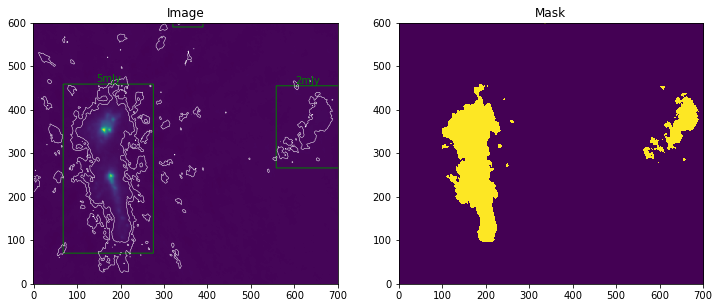

In [58]:
imname = 'W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal1'
image = SpectralCube.read(imname+'.image.tt0', format='casa_image')

regfn = os.path.join(alma_imf_code_path, 'clean_regions/W51-E_B6_selfcal1_robust0_12M.reg')

mask_regions = regions.read_ds9(regfn)

maskname = make_custom_mask('W51-E', imname+".image.tt0",
                            ALMAIMF_ROOTDIR,
                            'B6',
                            rootdir=os.getcwd(),
                            suffix='_selfcal1_robust0_12M',
                           )
#print(maskname)
mask = SpectralCube.read(maskname, format='casa_image')

x0, y0 = 850, 700
x1, y1 = 1550, 1300
dx = x1-x0
dy = y1-y0

pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.imshow(image[0].value[y0:y1,x0:x1], origin='lower', interpolation='none')
pl.contour(image[0].value[y0:y1,x0:x1], levels=[0.002, 0.005], colors=['w'], linewidths=[0.5,0.5])
pl.title("Image")
for reg in mask_regions:
    preg = reg.to_pixel(image[0].wcs)
    preg.plot(origin=(x0,y0))
    if preg.center.x-x0 > 0 and preg.center.x-x0 < dx and  preg.center.y-y0 > 0 and preg.center.y-y0 < dy:
        pl.text(preg.center.x-x0, preg.center.y-y0+preg.height/2, reg.meta['label'], color=reg.visual['color'], ha='center', va='bottom')
        
pl.subplot(1,2,2)
pl.imshow(mask[0].value[y0:y1,x0:x1], origin='lower', interpolation='none')
pl.title("Mask")

The region file specifies boxes in world coordinates and the labels are used to specify the threshold:

In [59]:
cat $regfn

# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
box(19:23:43.922,+14:30:29.228,12.442",23.328",6.80825e-06) # text={5mJy}
box(19:23:43.165,+14:30:52.297,4.147",7.050",6.80825e-06) # text={2mJy}
box(19:23:42.242,+14:30:54.856,16.327",10.020",6.80825e-06) # text={2mJy}
box(19:23:42.569,+14:30:04.501,12.338",8.916",6.80825e-06) # text={1mJy}
box(19:23:46.216,+14:29:47.645,8.359",6.480",6.80825e-06) # text={1mJy}
box(19:23:42.028,+14:30:34.987,8.653",11.339",6.80825e-06) # text={2mJy}


The region file names follow the format `{fieldname}_{band}{suffix}`, where fieldname is the field name as above and band is `B3` or `B6`.  The suffix is either `_dirty_robust{robust}_{arrayname}` for the dirty map or `_selfcal{selfcaliter}_robust{robust}_{arrayname}` for the self-calibration iterations.  Note that a different number can be used for each self-calibration iteration.  If there is a missing number, e.g., you specify iteration 1, 2, and 4, but not 3, the mask from the previous iteration will be used (in the example, #3 will use the mask from iteration #2).

Examples for W51 can be seen in the [clean_regions](https://github.com/ALMA-IMF/reduction/tree/master/reduction/clean_regions) directory of the code repository, which is where these files should be stored.

## Clean-region based masking

The other option is to use "clean boxes" drawn in CASA.  These can be exported in CRTF form.  In this case, the CRTF file needs to be specified in the imaging parameters.  For example:

```
imaging_parameters_nondefault = {
    'G333.60_B3_12M_robust0': {'threshold': {0: '1.0mJy', 1: '0.75mJy', 2: '0.50mJy', 3: '0.25mJy'}, 
                               'niter': {0: 1000, 1: 3000, 2: 9000, 3: 18000},
                               'maskname': {0: 'clean_mask1.crtf', 1: 'clean_mask2.crtf', 2: 'clean_mask3.crtf', 3: 'clean_mask4.crtf'}
                              },
                              }
```

An example clean region CRTF file is [G333_clean_mask1.crtf](https://github.com/ALMA-IMF/reduction/blob/master/reduction/clean_regions/G333_clean_mask1.crtf), which specifies a polygonal region drawn around the flux-containing region in the G333 B3 data.

# Examples

To see how this approach works in practice, look through [the W51 B6 example](https://github.com/ALMA-IMF/notebooks/blob/master/W51-E_B6_Selfcal.ipynb) and [the W51 B3 example](https://github.com/ALMA-IMF/notebooks/blob/master/W51E_B3_selfcal.ipynb).  These notebooks show each iteration of imaging as self-calibration progresses.  You can see the mask expand from one iteration to the next as well.  The Band 3 self-calibration example shows clearly that amplitude calibration is needed, as several artifacts disappear as soon as amplitude self-cal is applied.

These notebooks also include quantitative analysis toward the end, showing that the self-calibration increases the peak signal to noise by $\sim3\times$ (B6) and $\sim7\times$ (B3).